### Modeling

In [1]:
# Importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset (Here we use id 45 to fetch the cleveland dataset)
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

In [5]:
# Combine features and target into a single DataFrame
df = pd.concat([X, y], axis=1)
df.columns = list(X.columns) + ['target']  # Rename target column if necessary


In [6]:
# Step 1: We select features and recode target
# Important! These are chosen, based on the results from Brandon, Simmons (2021)
selected_features = ['oldpeak', 'cp', 'thalach', 'age', 'ca', 'thal']
X = df[selected_features]
y = df['target']


In [7]:
# Recode target variable into binary (0 = No Disease, 1 = Disease)
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

# Step 2: We split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)


In [9]:
# Step 3: Preprocessing
# One-hot encode categorical features
categorical_cols = ['cp', 'thal']
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_categorical = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]), 
                                   columns=encoder.get_feature_names_out(categorical_cols))
X_test_categorical = pd.DataFrame(encoder.transform(X_test[categorical_cols]), 
                                  columns=encoder.get_feature_names_out(categorical_cols))

# Combine categorical and numerical features
X_train = pd.concat([X_train.drop(categorical_cols, axis=1).reset_index(drop=True), X_train_categorical], axis=1)
X_test = pd.concat([X_test.drop(categorical_cols, axis=1).reset_index(drop=True), X_test_categorical], axis=1)

In [10]:
# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['oldpeak', 'thalach', 'age', 'ca']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [12]:
from sklearn.impute import SimpleImputer

# Step 4: We handle missing values, and bascily we
# replace missing values with the mean of each feature
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Step 5: Handle class imbalance with SMOTE
# This is done by oversampling the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_imputed, y_train)

print(f"Training set size (balanced): {X_train_balanced.shape}")
print(f"Test set size: {X_test.shape}")

Training set size (balanced): (262, 10)
Test set size: (61, 10)


Now that our data is split into training and test sets, it’s time to train and evaluate our model.

We’ll start by training the model on the training set to identify patterns within the data.
Next, we’ll test the model on the test set to evaluate how well it applies those patterns to unseen data.

Here are the three machine learning models we’ll be using:

> Logistic Regression
> Random Forest Classifier

In [15]:
# Step 5: Train and Evaluate Models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
}

# Impute missing values in X_test
X_test_imputed = imputer.transform(X_test)

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_imputed)
    y_prob = model.predict_proba(X_test_imputed)[:, 1]
    
    # Print performance metrics
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred, target_names=["No Disease", "Disease"]))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")
    


Training Logistic Regression...

Logistic Regression Performance:
              precision    recall  f1-score   support

  No Disease       0.93      0.82      0.87        33
     Disease       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

ROC-AUC Score: 0.95

Training Random Forest...

Random Forest Performance:
              precision    recall  f1-score   support

  No Disease       0.85      0.85      0.85        33
     Disease       0.82      0.82      0.82        28

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

ROC-AUC Score: 0.92


The training set was balanced using SMOTE, increasing its size to 262 samples to ensure the model learns equally from both classes (heart disease and no heart disease). The test set, containing 61 samples, was left unchanged to retain the original class imbalance, allowing for realistic evaluation. 

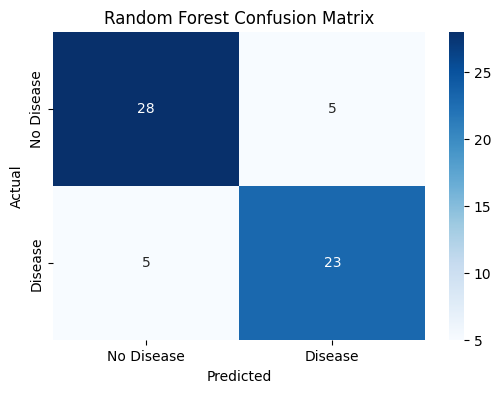

c:\Users\nickl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


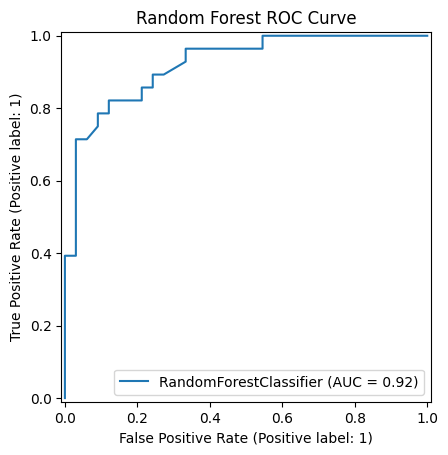

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.title(f"{name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual ")
plt.show()

# Plot ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title(f"{name} ROC Curve")
plt.show()

In [24]:
import pickle

# Save the Random Forest model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(models['Random Forest'], file)

# Save the Logistic Regression model (optional if needed)
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(models['Logistic Regression'], file)

print("Models saved successfully!")


Models saved successfully!
